In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt

In [5]:
df=pd.read_csv(r'C:\Users\Anupa\Desktop\Learnby- Machine learning & AI\Statistics & Machine Learning_August 2020\PPT & CODE\KNN\Social_Network_Ads.csv')

# Checking the data

In [6]:
df.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [7]:
df.dtypes

Age                int64
EstimatedSalary    int64
Purchased          int64
dtype: object

# Split Dependent and Independent

In [19]:
X=df.drop(['Purchased'],axis=1)
Y=df['Purchased']


In [9]:
Y.mean()

0.3575

# Missing Value Check

In [10]:
X.isnull().sum()/X.count()

Age                0.0
EstimatedSalary    0.0
dtype: float64

# Removing Features with 0 Variance

In [16]:
from sklearn.feature_selection import VarianceThreshold
varcutoff=VarianceThreshold()
X=pd.DataFrame(varcutoff.fit_transform(X),index=X.index,columns=X.columns)
X.describe(percentiles=[0.01,0.02,0.05,0.1,0.15,0.25,0.50,0.75,0.90,0.95,0.97,0.98,0.99])

,Age,EstimatedSalary
count,400.000000,400.000000
mean,37.655000,69742.500000
std,10.482877,34096.960282
min,18.000000,15000.000000
1%,18.000000,15990.000000
2%,19.000000,17000.000000
5%,21.000000,20950.000000
10%,24.000000,26000.000000
15%,26.000000,32000.000000
25%,29.750000,43000.000000


# Capping and Flooring of Outliers if Present

In [22]:
def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01))
    return x

In [23]:
X=X.apply(lambda x: outlier_capping(x))
X.describe()

,Age,EstimatedSalary
count,400.000000,400.000000
mean,37.655000,69737.500000
std,10.482877,34046.481507
min,18.000000,15990.000000
25%,29.750000,43000.000000
50%,37.000000,70000.000000
75%,46.000000,88000.000000
max,60.000000,148010.000000


In [24]:
X.shape

(400, 2)

# Feature Scaling for Enabling effectiveness of Distance Based Methods

In [25]:
from sklearn.preprocessing import StandardScaler
stdsc=StandardScaler()
X_std=pd.DataFrame(stdsc.fit_transform(X), index=X.index, columns=X.columns)

In [26]:
X_std.head(5)

,Age,EstimatedSalary
0,-1.781797,-1.492108
1,-0.253587,-1.462700
2,-1.113206,-0.786307
3,-1.017692,-0.374589
4,-1.781797,0.184170


In [27]:
X_std['Age'].mean()

-2.331468351712829e-16

In [28]:
X_std['Age'].std()

1.0012523486435185

# Train Test Split

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X_std,Y, test_size=0.2,random_state=42)

In [31]:
X_train['Age'].mean()

0.020714409932844825

In [32]:
X_test['Age'].mean()

-0.08285763973137994

# Check for randomness of train and test by testing the event rates across the two datasets

In [33]:
y_train.mean()

0.359375

In [34]:
y_test.mean()

0.35

In [35]:
X_test.shape

(80, 2)

# Building the KNN Model

In [36]:
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier(n_neighbors = 5, weights='uniform',metric = 'minkowski', p = 2)
clf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

# Making Class Predictions

In [37]:
y_pred=clf.predict(X_test)

# Model Evaluation

In [38]:
from sklearn import metrics

In [39]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision",metrics.precision_score(y_test,y_pred))
print("Recall",metrics.recall_score(y_test,y_pred))
print("f1_score",metrics.f1_score(y_test,y_pred))

Accuracy: 0.925
Precision 0.8666666666666667
Recall 0.9285714285714286
f1_score 0.896551724137931


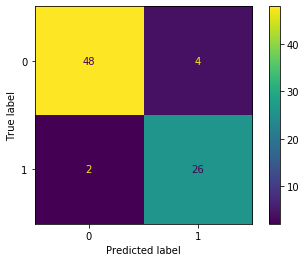

In [40]:
metrics.plot_confusion_matrix(clf,X_test,y_test)

In [41]:
metrics.roc_auc_score(y_test,y_pred)

0.9258241758241759

# Visualizing the Model Performance - Lorenz Curve

In [42]:
y_pred_prob = clf.predict_proba(X)[:, 1]
df['y_pred_P']=pd.DataFrame(y_pred_prob)
df['P_Rank_RF']=pd.qcut(df['y_pred_P'].rank(method='first').values,10,duplicates='drop').codes+1
rank_df=df.groupby('P_Rank_RF')['Purchased'].agg(['count','mean'])
rank_df=pd.DataFrame(rank_df)
sorted_rank_df=rank_df.sort_values(by='P_Rank_RF',ascending=False)
sorted_rank_df['N_events']=rank_df['count']*rank_df['mean']
sorted_rank_df['cum_events']=sorted_rank_df['N_events'].cumsum()
sorted_rank_df['event_cap']=sorted_rank_df['N_events']/max(sorted_rank_df['N_events'].cumsum())
sorted_rank_df['cum_event_cap']=sorted_rank_df['event_cap'].cumsum()
sorted_rank_df['random_cap']=sorted_rank_df['count']/max(sorted_rank_df['count'].cumsum())
sorted_rank_df['cum_random_cap']=sorted_rank_df['random_cap'].cumsum()
sorted_reindexed=sorted_rank_df.reset_index()
sorted_reindexed['decile']=sorted_reindexed.index+1
sorted_reindexed['lift_over_random']=sorted_reindexed['cum_event_cap']/sorted_reindexed['cum_random_cap']
sorted_reindexed

,P_Rank_RF,count,mean,N_events,cum_events,event_cap,cum_event_cap,random_cap,cum_random_cap,decile,lift_over_random
0,10,40,0.750,30.0,30.0,0.209790,0.209790,0.1,0.1,1,2.097902
1,9,40,0.525,21.0,51.0,0.146853,0.356643,0.1,0.2,2,1.783217
2,8,40,0.575,23.0,74.0,0.160839,0.517483,0.1,0.3,3,1.724942
3,7,40,0.600,24.0,98.0,0.167832,0.685315,0.1,0.4,4,1.713287
4,6,40,0.475,19.0,117.0,0.132867,0.818182,0.1,0.5,5,1.636364
5,5,40,0.075,3.0,120.0,0.020979,0.839161,0.1,0.6,6,1.398601
6,4,40,0.075,3.0,123.0,0.020979,0.860140,0.1,0.7,7,1.228771
7,3,40,0.075,3.0,126.0,0.020979,0.881119,0.1,0.8,8,1.101399
8,2,40,0.075,3.0,129.0,0.020979,0.902098,0.1,0.9,9,1.002331
9,1,40,0.350,14.0,143.0,0.097902,1.000000,0.1,1.0,10,1.000000


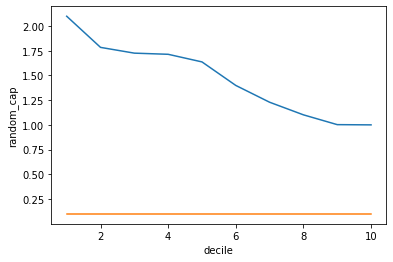

In [43]:
ax = sns.lineplot( x="decile", y="lift_over_random", data=sorted_reindexed)
ax = sns.lineplot( x="decile", y="random_cap", data=sorted_reindexed)

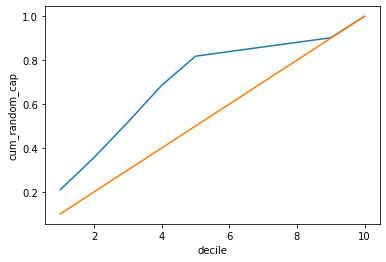

In [44]:
ax = sns.lineplot( x="decile", y="cum_event_cap", data=sorted_reindexed)
ax = sns.lineplot( x="decile", y="cum_random_cap", data=sorted_reindexed)